<h1> Important Libraries To Install </h1>

In [1]:
!pip install shap --quiet
!pip install opencv-python --quiet
!pip install swig --quiet
!pip install Box2D --quiet
!pip install gym --quiet
!pip install pyglet==1.5.27 --quiet
!pip install stable_baselines3 --quiet
!pip install "gymnasium[all]" --quiet
!pip install stable_baselines3 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.9/427.9 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.2/182.2 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 83.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import numpy as np
import random
import scipy.stats as stats
import imageio
import gymnasium as gym
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import shap

from stable_baselines3 import DQN, A2C, PPO
from stable_baselines3.common import results_plotter
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack, SubprocVecEnv, VecNormalize, VecVideoRecorder

In [3]:
# Set seed for reproducibility
np.random.seed(100)  # Numpy module
random.seed(100)  # Python's random module
tf.random.set_seed(100)  # TensorFlow

<h1> Parameter & Environment Information </h1>

<p>
    This environment is part of the Box2D environments.
</p>

<ul>
    <li> Action Space Discrete(4) </li>
    <li> Observation Shape (8,) </li>
    <li> Observation High [1.5 1.5 5. 5. 3.14 5. 1. 1. ] </li>
    <li> Observation Low [-1.5 -1.5 -5. -5. -3.14 -5. -0. -0. ] </li>
    <li> Import gymnasium.make("LunarLander-v2") </li>
</ul>

<h3> Description </h3>
<p>This environment is a classic rocket trajectory optimization problem. According to Pontryagin’s maximum principle, it is optimal to fire the engine at full throttle or turn it off. This is the reason why this environment has discrete actions: engine on or off.

There are two environment versions: discrete or continuous. The landing pad is always at coordinates (0,0). The coordinates are the first two numbers in the state vector. Landing outside of the landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt.</p>

<h3> Action Space </h3>
<p>
There are four discrete actions available:

* 0: do nothing
* 1: fire left orientation engine
* 2: fire main engine
* 3: fire right orientation engine

</p>

<h3> Observation Space </h3>
<p>
The state is an 8-dimensional vector: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.
</p>

<h3> Reward </h3>
<p>
After every step a reward is granted. The total reward of an episode is the sum of the rewards for all the steps within that episode.

For each step, the reward:

* is increased/decreased the closer/further the lander is to the landing pad.
* is increased/decreased the slower/faster the lander is moving.
* is decreased the more the lander is tilted (angle not horizontal).
* is increased by 10 points for each leg that is in contact with the ground.
* is decreased by 0.03 points each frame a side engine is firing.
* is decreased by 0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.

An episode is considered a solution if it scores at least 200 points.
</p>

<h3> Starting State </h3>

<p>The lander starts at the top center of the viewport with a random initial force applied to its center of mass.</p>

<h3> Episode Termination </h3>
<p> The episode finishes if:<br>
    
1. the lander crashes (the lander body gets in contact with the moon);<br>
2. the lander gets outside of the viewport (x coordinate is greater than 1);<br>
3. the lander is not awake. From the Box2D docs, a body which is not awake is a body which doesn’t move and doesn’t collide with any other body:<br>

When Box2D determines that a body (or group of bodies) has come to rest, the body enters a sleep state which has very little CPU overhead. If a body is awake and collides with a sleeping body, then the sleeping body wakes up. Bodies will also wake up if a joint or contact attached to them is destroyed.

Reference: https://www.gymlibrary.dev/environments/box2d/lunar_lander/
</p>

In [4]:
env = gym.make("LunarLander-v2", render_mode="human")

In [5]:
print("The action space is discrete with {} actions".format(env.action_space.n))
print("The shape of the observation space is {}".format(env.observation_space.shape))

The action space is discrete with 4 actions
The shape of the observation space is (8,)


<h1> Baseline Model </h1>

Running this loop with random actions allows for a basic evaluation of the environment's response dynamics and the distribution of rewards for arbitrary actions. It's a way to understand the range of outcomes possible from random decisions, serving as a baseline to assess the performance of more sophisticated algorithms. It helps in identifying how the environment behaves and what rewards can be expected on average without any specific strategy.

In [6]:
# Initialize the environment
obs = env.reset()
done = False
rewards = []
MAX_RUN = 10  # Set the maximum number of episodes

# Main loop to run episodes
for i in range(MAX_RUN):
    while not done:
        env.render()  # Render the environment for visualization
        action_sample = env.action_space.sample()  # Sample a random action
        # Take a step in the environment with the sampled action
        obs, rwd, done, info, _ = env.step(action_sample)
        rewards.append(rwd)  # Collect reward
    done = False  # Reset the done flag for the next episode
    obs = env.reset()  # Reset the environment for the next episode

env.close()  # Close the environment after running the episodes

# Print the mean reward after the specified number of runs
print("Mean Reward after {} max runs is {}".format(MAX_RUN, np.mean(np.array(rewards))))


Mean Reward after 10 max runs is -1.926741512512965


<h1> Reinforcement Learning For Training The Model </h1>

This class is a callback for saving the best-performing model during training in reinforcement learning, based on the highest average reward achieved over a set number of episodes.

In [7]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    This callback saves the model based on the best training reward achieved,
    checked every specified number of steps (`check_freq`).
    It's designed for use in reinforcement learning where monitoring and
    saving based on performance is crucial.

    Parameters:
    - check_freq: Frequency of evaluation/check (in steps).
    - log_dir: Directory to save the best model and log files.
    - verbose: Verbosity level.
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self):
        """Prepare the environment at the start of training."""
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        """Check and save the model at each step."""
        # Only proceed if it's time to check based on `check_freq`
        if self.n_calls % self.check_freq == 0:
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            if len(x) > 0:
                mean_reward = np.mean(y[-100:])  # Average reward of the last 100 episodes

                # Log the current performance
                if self.verbose:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

                # Save the model if it performed better
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    if self.verbose:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True


In [ ]:
train_from_file = False
# Hyperparameters are from RL_Zoo
# https://github.com/DLR-RM/rl-baselines3-zoo/blob/master/hyperparams/dqn.yml


n_timesteps = 8e6
policy =  'MlpPolicy'
learning_rate = 6.3e-4
batch_size = 128
buffer_size = 50000
# learning_starts = 0
gamma = 0.99
target_update_interval = 250
train_freq = 4
gradient_steps = -1
exploration_fraction = 0.12
exploration_final_eps = 0.1
policy_kwargs = "dict(net_arch=[256, 256])"

n_envs = 1


callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir="log_dir_DQN/")

# env
env = make_vec_env("LunarLander-v2", n_envs=n_envs, monitor_dir="log_dir_DQN/")

# instantiate the agent
if train_from_file:
  model = DQN.load(path="log_dir_DQN/best_model.zip", env=env)
else:
  model = DQN(
      policy,
      env,
      # learning_rate = learning_rate,
      # batch_size = batch_size,
      # buffer_size = buffer_size,
      # learning_starts = learning_starts,
      # gamma = gamma,
      # target_update_interval = target_update_interval,
      # train_freq = train_freq,
      # gradient_steps = gradient_steps,
      # exploration_fraction = exploration_fraction,
      # exploration_final_eps = exploration_final_eps,
      # policy_kwargs = dict(net_arch=[256, 256]),
      tensorboard_log="./TensorBoardLog/", verbose=1)

# train the agent
model.learn(total_timesteps=n_timesteps, callback=callback)

Using cpu device
Logging to ./TensorBoardLog/DQN_2
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 81.5     |
|    ep_rew_mean      | -189     |
|    exploration_rate | 1        |
| time/               |          |
|    episodes         | 4        |
|    fps              | 3943     |
|    time_elapsed     | 0        |
|    total_timesteps  | 326      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 84.5     |
|    ep_rew_mean      | -168     |
|    exploration_rate | 0.999    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 3909     |
|    time_elapsed     | 0        |
|    total_timesteps  | 676      |
----------------------------------
Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: -164.69
Saving new best model to log_dir_DQN/best_model.zip
----------------------------------
| rollout

# Plotting

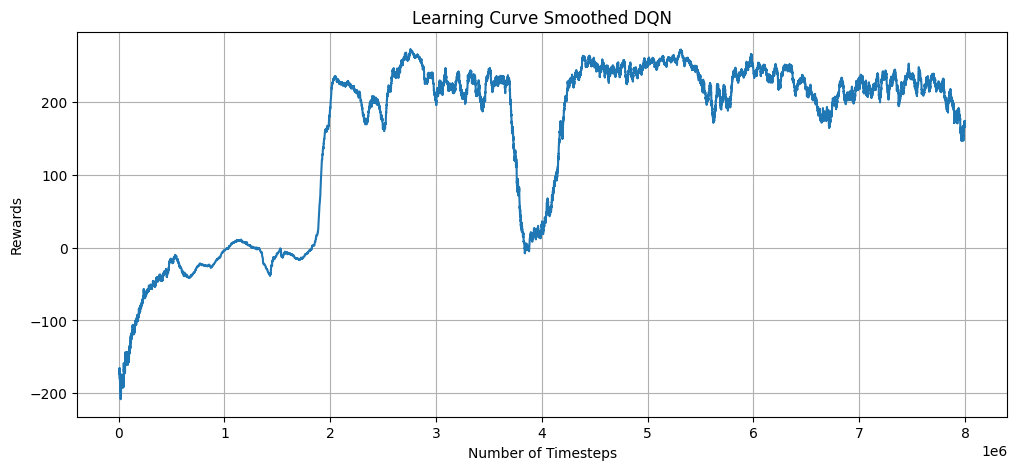

In [ ]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')

def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """

    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=100)
    # Truncate x
    x = x[len(x) - len(y):]
    fig = plt.figure(title, figsize=(12,5))
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed DQN")
    plt.grid()
    plt.show()

plot_results("log_dir_DQN")

# Evaluation

In [ ]:
env = make_vec_env("LunarLander-v2", n_envs=1,monitor_dir="evalaute_log_dir_DQN")

In [ ]:
model = DQN.load(path="log_dir_DQN/best_model.zip")

#### Stable Baseline 3 Evaluation Function.

In [ ]:
mean_reward, std_reward = evaluate_policy(model, env,n_eval_episodes=10, render=True, deterministic=True)
print("Mean & Std Reward after {} max run is {} & {}".format(10,mean_reward, std_reward))

Mean & Std Reward after 10 max run is 247.11298789999995 & 40.11324699409995


# GIF of a Train Agent

In [ ]:
env = make_vec_env("LunarLander-v2", n_envs=1)
model = DQN.load(path="log_dir_DQN/best_model.zip")

images = []
obs = env.reset()
img = env.render(mode="rgb_array")
for i in range(1000):
    images.append(img)
    action, _ = model.predict(obs)
    obs, _, _ ,_ = env.step(action)
    img = env.render(mode="rgb_array")

imageio.mimsave("lunar lander_DQN.gif", [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)
